In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
import galaxyfunctions as func

from astropy import units as u
from scipy.constants import G

In [29]:
#import mass lists
size_list = np.load('galaxy_size_list.npy')
bm_list = np.load('bulge_mass_list.npy')
mwdm_list = np.load('mwdisk_mass_list.npy')
hm_list = np.load('halo_mass_list.npy')
m_tot = bm_list + mwdm_list + hm_list

In [30]:
#changing units
msun_kg = ((1*u.solMass)/(1*u.kg)).to(u.kg/u.kg).value
kpc_m = ((1*u.kpc)/(1*u.meter)).to(u.meter/u.meter).value
s_myr = ((1*u.s)/(1*u.Myr)).to(u.s/u.s).value

In [31]:
def m_arr(r_list,src='full'):
    idx = np.argmin(abs(size_list[:,np.newaxis]-r_list[np.newaxis,:]),axis=0)
    if src=='full':
        return m_tot[idx]
    elif src=='bulge':
        return bm_list[idx]
    elif src=='disk':
        return mwdm_list[idx]
    elif src=='halo':
        return hm_list[idx]
    else:
        print('Error!')
        assert False
        
def v(r_list,src='full'):
    v_list = []
    v_list.append(np.sqrt(G*m_arr(r_list,src)*msun_kg/(r_list*kpc_m)))
    return np.array(v_list)[0] #m/s

def vi(r,theta):
    v1 = v(r)
    vx = v1*np.cos(theta-np.pi/2)/s_myr/kpc_m
    vy = v1*np.sin(theta-np.pi/2)/s_myr/kpc_m
    return vx,vy #[kpc/Myr]

In [32]:
def initialize(N_objects,r_min,r_max,M_min,M_max):
    theta0 = np.random.uniform(0,2*np.pi,N_objects)
    r0 = np.random.uniform(r_min,r_max,N_objects)
    M_list = np.random.uniform(M_min,M_max,N_objects) 

    # velocities
    vx0, vy0 = vi(r0,theta0)

    # xy-coordinates
    x0 = r0*np.cos(theta0)
    y0 = r0*np.sin(theta0)
    
    return x0,y0,vx0,vy0,M_list

In [33]:
# Initial positions and masses of objects
N_objects = 1000
r_min = 0.1 #[kpc]
r_max = 30  #[kpc]
M_min = 0.1 #[Msun]
M_max = 10  #[Msun]

x0,y0,vx0,vy0,M_list = initialize(N_objects,r_min,r_max,M_min,M_max)

In [34]:
with open('mwinitial_conditions.npy', 'wb') as f:
    np.save(f, [x0, y0, vx0, vy0])
    
with open('mwstar_masses.npy', 'wb') as f:
    np.save(f, M_list)

In [35]:
x0, y0, vx0, vy0 = np.load('mwinitial_conditions.npy')
m_list = np.load('mwstar_masses.npy')

In [36]:
def F(xlist, ylist, mlist):
    dx = -(xlist[:, np.newaxis] - xlist[np.newaxis,:]) * kpc_m
    dy = -(ylist[:, np.newaxis] - ylist[np.newaxis,:]) * kpc_m
    d = np.sqrt(np.add(np.power(dx, 2), np.power(dy, 2)))
    d3 = np.power(d, 3)
    
    mm = (mlist[:, np.newaxis] * mlist[np.newaxis,:]) * msun_kg**2
    Gmm = np.multiply(G, mm)
    
    fxn = np.nansum(np.multiply(np.divide(Gmm, d3), dx), axis = 1)
    fyn = np.nansum(np.multiply(np.divide(Gmm, d3), dy), axis = 1)
    
    r = np.sqrt(xlist**2 + ylist**2)
    m = m_arr(r) * msun_kg
    fxg = G * m * (mlist * msun_kg)/(r * kpc_m)**3 * (-xlist * kpc_m)
    fyg = G * m * (mlist * msun_kg)/(r * kpc_m)**3 * (-ylist * kpc_m)
    
    fx = fxn + fxg
    fy = fyn + fyg
    return fx, fy

In [37]:
for _ in range(100):
    fx, fy = F(x0, y0, m_list)

<ipython-input-36-f896e4fa9afa>:10: RuntimeWarning: divide by zero encountered in true_divide
  fxn = np.nansum(np.multiply(np.divide(Gmm, d3), dx), axis = 1)
<ipython-input-36-f896e4fa9afa>:10: RuntimeWarning: invalid value encountered in multiply
  fxn = np.nansum(np.multiply(np.divide(Gmm, d3), dx), axis = 1)
<ipython-input-36-f896e4fa9afa>:11: RuntimeWarning: divide by zero encountered in true_divide
  fyn = np.nansum(np.multiply(np.divide(Gmm, d3), dy), axis = 1)
<ipython-input-36-f896e4fa9afa>:11: RuntimeWarning: invalid value encountered in multiply
  fyn = np.nansum(np.multiply(np.divide(Gmm, d3), dy), axis = 1)


In [38]:
a_rescale = (1/kpc_m)/(s_myr**2)

In [39]:
def deriv(val, M_list):
    x_list, y_list, vx_list, vy_list = val
    
    dxdt = vx_list
    dydt = vy_list
    
    Fx, Fy = F(x_list, y_list, M_list)
    dvxdt = Fx / (M_list * msun_kg) * a_rescale
    dvydt = Fy / (M_list * msun_kg) * a_rescale
    
    return np.array([dxdt, dydt, dvxdt, dvydt])

In [40]:
def RK4(val_old, dt, M_list):
    val_old = np.array(val_old)
    k1 = val_old + 0.5*dt*deriv(val_old, M_list) 
    k2 = val_old + 0.5*dt*deriv(k1, M_list)
    k3 = val_old + dt*deriv(k2, M_list)
    k4 = dt*deriv(k3, M_list)
    
    return (k1 + 2*k2 + k3)/3 + k4/6 - val_old/3

In [41]:
def simulation(val0, M_list, dt, t_max, save):
    t = 0
    val_old = val0
    data = []
    t_list = []
    while t <= t_max:
        val_new = RK4(val_old, dt, M_list) 
        t += dt
        
        if t % save == 0:
            data.append(val_new)
            t_list.append(t)
        val_old = val_new
    return data, t_list

In [42]:
val0 = [x0, y0, vx0, vy0]
dt = 0.5
tmax = 300
save = 1

data, t_list = simulation(val0, m_list, dt, tmax, save) 

<ipython-input-36-f896e4fa9afa>:10: RuntimeWarning: divide by zero encountered in true_divide
  fxn = np.nansum(np.multiply(np.divide(Gmm, d3), dx), axis = 1)
<ipython-input-36-f896e4fa9afa>:10: RuntimeWarning: invalid value encountered in multiply
  fxn = np.nansum(np.multiply(np.divide(Gmm, d3), dx), axis = 1)
<ipython-input-36-f896e4fa9afa>:11: RuntimeWarning: divide by zero encountered in true_divide
  fyn = np.nansum(np.multiply(np.divide(Gmm, d3), dy), axis = 1)
<ipython-input-36-f896e4fa9afa>:11: RuntimeWarning: invalid value encountered in multiply
  fyn = np.nansum(np.multiply(np.divide(Gmm, d3), dy), axis = 1)


In [43]:
with open('mwdata.npy', 'wb') as f:
    np.save(f, [data, t_list])

C:\Users\megan\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [44]:
from matplotlib.animation import FuncAnimation
#remove second axis

def animation(data_a, t_lista, filename, fps = 60, distinguish_extra_obj = False, alpha = 1.0):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (17, 8))
    
    x1, y1 = [], []
    x2, y2 = [], []
    x3, y3 = [], []
    
    sc1, = ax1.plot(x1, y1, marker = 'o', ls = '', ms = 15, zorder = 1, markeredgecolor = 'none', color = 'pink')
    sc2, = ax1.plot(x2, y2, marker = 'o', ls = '', ms = 2, zorder = 1, markeredgecolor = 'none', color = 'purple', alpha = alpha)
    sc3, = ax2.plot(x3, y3, marker ='o', ls = '', ms = 2, markeredgecolor = 'none', alpha = alpha)
    text = ax1.text(10, 35, '', fontdict={'color':'lightblue', 'size':20})
    
    def init():
        ax1.set_aspect('equal')
        ax1.set_xlim(-40, 40)
        ax1.set_ylim(-40, 40)
        ax1.set_xlabel('x [kpc]')
        ax1.set_ylabel('y [kpc]')
        ax2.set_xlabel('r [kpc]')
        ax2.set_ylabel('v [kpc/Myr]')
        ax2.set_ylim(0, 30)
        ax2.set_xlim(0, 40)
        fig.patch.set_facecolor('black')
        
        for ax in [ax1, ax2]:
            ax.set_facecolor('black')
            ax.spines['bottom'].set_color('lightblue')
            ax.spines['top'].set_color('lightblue')
            ax.spines['right'].set_color('lightblue')
            ax.spines['left'].set_color('lightblue')
            ax.xaxis.label.set_color('lightblue')
            ax.yaxis.label.set_color('lightblue')
            ax.tick_params(axis = 'x', colors = 'lightblue')
            ax.tick_params(axis = 'y', colors = 'lightblue')
            
        return sc1, sc2, sc3, text,
    
    def update(frame):
        x, y, vx, vy = data_a[frame]
        
        if distinguish_extra_obj:
            sc1.set_data(x[0], y[0])
            sc2.set_data(x[1:], y[1:])
            sc3.set_data(np.sqrt(x**2 + y**2)[1:], np.sqrt(vx**2 + vy**2)[1:])
        else:
            sc2.set_data(x, y)
            sc3.set_data(np.sqrt(x**2 + y**2), np.sqrt(vx**2 + vy**2))
            text.set_text(f't = {int(t_lista[frame]):} Myr')
            return sc1, sc2, sc3, text,
        
    ani = FuncAnimation(fig, update, frames = len(data_a), init_func = init, blit = True)
    ani.save(filename, fps = fps, dpi = 200, savefig_kwargs = {'facecolor':'black'})
    print('done')

MovieWriter ffmpeg unavailable; using Pillow instead.


done


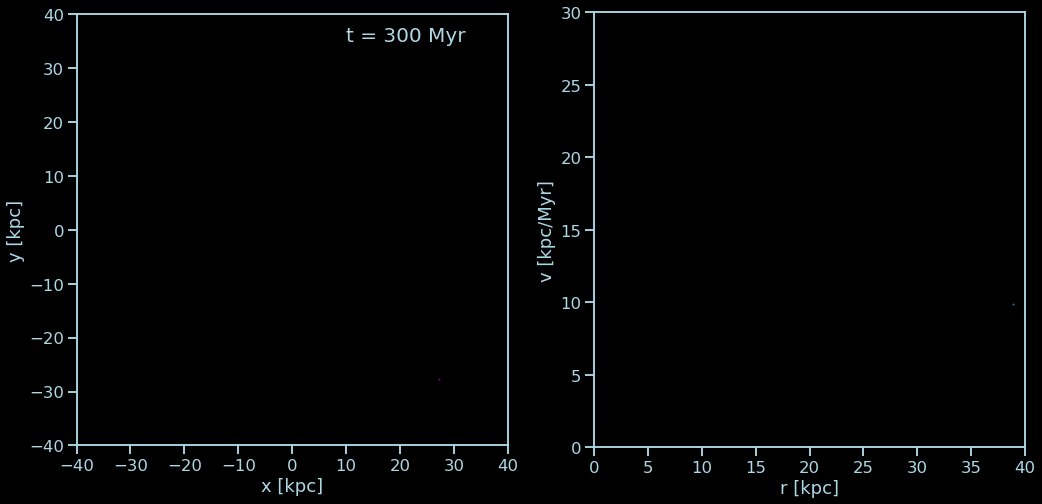

In [45]:
animation(data, t_list, 'mwgalaxyanimation.gif')

In [46]:
# Initial positions and masses of objects
N_objects = 1000
r_min = 0.1 #[kpc]
r_max = 30  #[kpc]
M_min = 0.1 #[Msun]
M_max = 100 #[Msun]

x_0,y0,vx0,vy0,M_list = initialize(N_objects,r_min,r_max,M_min,M_max)

x02 = np.concatenate([[-10],x0])
y02 = np.concatenate([[-50],y0])
vx02 = np.concatenate([[0],vx0])
vy02 = np.concatenate([[0.17],vy0])
M_list2 = np.concatenate([[1e10],m_list])

In [47]:
val02 = [x02,y02,vx02,vy02]
dt = 0.5
tmax = 3600
save_interval = 1

data2,t_list2 = run_simulation(val02,M_list2,dt,tmax,save_interval)

NameError: name 'run_simulation' is not defined

In [ ]:
with open('data2.npy', 'wb') as f:
    np.save(f, [data2, t_list2])

In [ ]:
animation(data2, t_list2, 'mwgalaxyanimation2.gif',distinguish_extra_obj=True)